In [1]:
import gif
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import datetime
from tqdm import tqdm
from skforecast.model_selection.model_selection import _create_backtesting_folds

import warnings
warnings.filterwarnings('ignore')

## Data

,y
date,
1991-07-01,0.429795
1991-08-01,0.400906
1991-09-01,0.432159


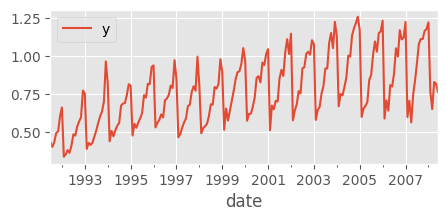

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data_gif = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data_gif['fecha'] = pd.to_datetime(data_gif['fecha'], format='%Y-%m-%d')
data_gif = data_gif.rename(columns={"fecha": "date"}, errors="raise")
data_gif = data_gif.set_index('date')
data_gif = data_gif.rename(columns={'x': 'y'})
data_gif = data_gif.asfreq('MS')
data_gif = data_gif.sort_index()
display(data_gif.head(3))

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
data_gif.plot(ax=ax)
ax.legend();

## Create folds

In [4]:
folds = _create_backtesting_folds(
            data                  = data_gif['y'],
            window_size           = 12,
            test_size             = 10,
            initial_train_size    = 96,
            gap                   = 0,
            refit                 = 4,
            fixed_train_size      = False,
            allow_incomplete_fold = True,
            return_all_indexes    = False,
            verbose               = False  
        )

folds

[[[0, 96], [84, 96], [96, 106], [96, 106], False],
 [[0, 96], [94, 106], [106, 116], [106, 116], False],
 [[0, 96], [104, 116], [116, 126], [116, 126], False],
 [[0, 96], [114, 126], [126, 136], [126, 136], False],
 [[0, 136], [124, 136], [136, 146], [136, 146], True],
 [[0, 136], [134, 146], [146, 156], [146, 156], False],
 [[0, 136], [144, 156], [156, 166], [156, 166], False],
 [[0, 136], [154, 166], [166, 176], [166, 176], False],
 [[0, 176], [164, 176], [176, 186], [176, 186], True],
 [[0, 176], [174, 186], [186, 196], [186, 196], False],
 [[0, 176], [184, 196], [196, 204], [196, 204], False]]

In [3]:
#  Ampliar unos meses con df vacío para mejor visualización
ampliar = True
meses_ampliar = 1

if ampliar:
    last_date = data_gif.index[-1]
    end = data_gif.index[-1] + datetime.timedelta(days=meses_ampliar*30)
    index = pd.date_range(last_date, end=end, freq='D')
    df_plot = pd.DataFrame(index=index)
    df_plot = pd.concat([data_gif, df_plot])
else:
    df_plot = data_gif.copy()

df_plot.tail(3)

,y
2008-06-29,NaN
2008-06-30,NaN
2008-07-01,NaN


In [13]:
@gif.frame
def custom_plot(df_plot, fold, title):
    
    palette_btc = {'naranja': '#f7931a',
                   'blanco' : '#ffffff',
                   'gris' : '#4d4d4d',
                   'azul' : '#0d579b',
                   'verde' : '#329239'
                  }
            
    min_y = df_plot['y'].min()
    max_y = df_plot['y'].max()
    
    start_train = fold[0][0]
    end_train = fold[0][1]
    start_gap = fold[1][0]
    end_gap = fold[2][0]
    start_test = fold[2][0]
    end_test = fold[2][1]

    train = (df_plot.index[start_train], df_plot.index[end_train])
    gap = (df_plot.index[start_gap], df_plot.index[end_gap])  
    test = (df_plot.index[start_test], df_plot.index[end_test])  
    
    xlabels = [""]
    for year in df_plot.index.year.unique():
        xlabels.append(year)
    
    # Plot
    # ==============================================================================
    fig, ax=plt.subplots(figsize=(9, 4))
    df_plot['y'].plot(ax=ax)
    ax.fill_between(train, min_y, max_y, facecolor=palette_btc['verde'], alpha=0.4, zorder=0, label='Train')
    if start_gap != end_gap:
        ax.fill_between(gap, min_y, max_y, facecolor=palette_btc['gris'], alpha=0.4, zorder=0, label='Gap')
    ax.fill_between(test, min_y, max_y, facecolor=palette_btc['azul'], alpha=0.4, zorder=0, label='Test')
    ax.set_xticklabels(xlabels, rotation=45, ha='center')
    ax.legend()
    ax.set_title(title)
        
    return ax

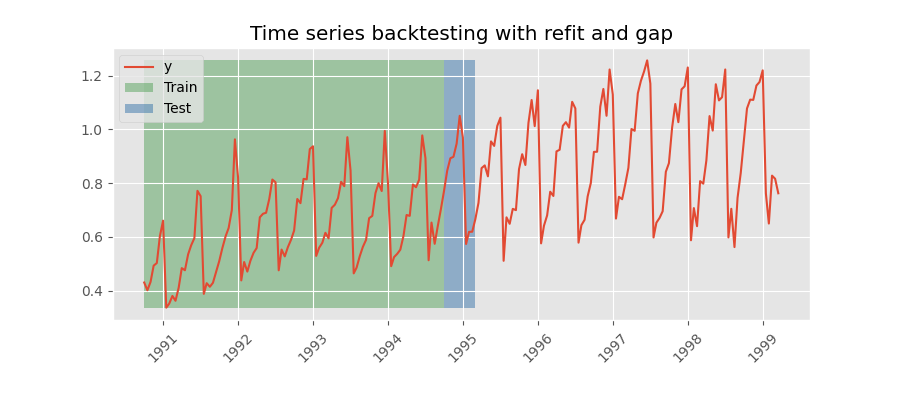

In [14]:
custom_plot(df_plot, folds[0], 'Time series backtesting with refit and gap')

In [18]:
duracion_gif = 700 # miliseconds
title = 'Time series backtesting intermittent refit'

folds = _create_backtesting_folds(
            data                  = data_gif['y'],
            test_size             = 10,
            initial_train_size    = 86,
            gap                   = 0,
            refit                 = 4,
            fixed_train_size      = False,
            allow_incomplete_fold = True,
            return_all_indexes    = False,
            verbose               = False  
        )

frames = []
for fold in tqdm(folds):

    frame = custom_plot(df_plot, fold, title)
    frames.append(frame)


name = 'backtesting_intermittent_refit'

gif.save(frames, f'./{name}.gif', duration=duracion_gif)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:02<00:00,  4.59it/s]


## GIf Predictions with extended lag periods

In [ ]:
[[[0, 168], [84, 96], [96, 106], [96, 106], False],
 [[0, 96], [94, 106], [106, 116], [106, 116], False],
 [[0, 96], [104, 116], [116, 126], [116, 126], False],
 [[0, 96], [114, 126], [126, 136], [126, 136], False],
 [[0, 136], [124, 136], [136, 146], [136, 146], True],
 [[0, 136], [134, 146], [146, 156], [146, 156], False],
 [[0, 136], [144, 156], [156, 166], [156, 166], False],
 [[0, 136], [154, 166], [166, 176], [166, 176], False],
 [[0, 176], [164, 176], [176, 186], [176, 186], True],
 [[0, 176], [174, 186], [186, 196], [186, 196], False],
 [[0, 176], [184, 196], [196, 204], [196, 204], False]]

In [75]:
# Train, last_window, test, predictions

folds = []
start_pred = 168

for i in range(168, 168+36, 6):
    fold = [[0, 168], [start_pred-42, start_pred-30], [start_pred+1, start_pred+36], [start_pred+1, start_pred+6]]
    folds.append(fold)

    start_pred += 6

folds

[[[0, 168], [126, 138], [169, 204], [169, 174]],
 [[0, 168], [132, 144], [175, 210], [175, 180]],
 [[0, 168], [138, 150], [181, 216], [181, 186]],
 [[0, 168], [144, 156], [187, 222], [187, 192]],
 [[0, 168], [150, 162], [193, 228], [193, 198]],
 [[0, 168], [156, 168], [199, 234], [199, 204]]]

In [8]:
@gif.frame
def custom_plot(df_plot, start_predictions, fold, title):
    
    palette_btc = {'naranja': '#f7931a',
                   'blanco' : '#ffffff',
                   'gris' : '#4d4d4d',
                   'azul' : '#0d579b',
                   'verde' : '#329239'
                  }
            
    min_y = df_plot['y'].min()
    max_y = df_plot['y'].max()
    
    start_train = fold[0][0]
    end_train = fold[0][1]
    start_lw = fold[1][0]
    end_lw = fold[1][1]
    start_test = fold[2][0]
    end_test = fold[2][1]
    start_pred = fold[3][0]
    end_pred = fold[3][1]

    train = (df_plot.index[start_train], df_plot.index[end_train])
    lw = (df_plot.index[start_lw], df_plot.index[end_lw])  
    # test = (df_plot.index[start_pred], df_plot.index[end_pred])  
    pred = (df_plot.index[start_pred], df_plot.index[end_pred])  
    
    xlabels = [""]
    for year in df_plot.index.year.unique():
        xlabels.append(year)
    
    # Plot
    # ==============================================================================
    fig, ax=plt.subplots(figsize=(9, 4))

    df_plot['y'].plot(ax=ax, alpha=0, label='_nolegend_', color='black')
    df_plot.dropna().iloc[start_train:end_train]['y'].plot(ax=ax, label='_nolegend_')
    df_plot.dropna().iloc[start_predictions+1:end_pred]['y'].plot(ax=ax, label='_nolegend_')
    df_plot.dropna().iloc[start_test:end_test]['y'].plot(ax=ax, alpha=0, label='_nolegend_')

    ax.fill_between(train, min_y, max_y, facecolor=palette_btc['verde'], alpha=0.2, zorder=0, label='Train')
    ax.fill_between(lw, min_y, max_y, facecolor=palette_btc['naranja'], alpha=0.4, zorder=0, label='Last window')
    ax.fill_between(pred, min_y, max_y, facecolor=palette_btc['azul'], alpha=0.4, zorder=0, label='Steps')

    ax.set_xticklabels(xlabels, rotation=45, ha='center')
    ax.legend()
    ax.set_title(title)
        
    return ax

In [9]:
custom_plot(df_plot, 162, folds[-1], 'Time series backtesting with refit and gap')

NameError: name 'folds' is not defined

In [10]:
duracion_gif = 700 # miliseconds
title = 'Predictions with extended lags periods'

folds = []
start_pred = 156

for i in range(start_pred, start_pred+48, 6):
    fold = [[0, 156], [start_pred-54, start_pred-42], [start_pred+1, start_pred+49], [start_pred+1, start_pred+7]]
    folds.append(fold)

    start_pred += 6

frames = []
start_pred = 156
for fold in tqdm(folds):

    frame = custom_plot(df_plot, start_predictions=start_pred, fold=fold, title=title)
    frames.append(frame)


name = 'predict_extended_lags_periods'

gif.save(frames, f'./{name}.gif', duration=duracion_gif)

100%|██████████| 8/8 [00:01<00:00,  5.34it/s]


In [12]:
@gif.frame
def custom_plot2(df_plot, title):

    palette_btc = {'naranja': '#f7931a',
                'blanco' : '#ffffff',
                'gris' : '#4d4d4d',
                'azul' : '#0d579b',
                'verde' : '#329239'
                }

    xlabels = [""]
    for year in df_plot.index.year.unique():
        xlabels.append(year)

    # Plot
    # ==============================================================================
    start_train = 0
    end_train = 156
    start_pred = 156+1
    end_pred = -1

    min_y = df_plot['y'].min()
    max_y = df_plot['y'].max()
    train = (df_plot.index[start_train], df_plot.index[end_train])
    pred = (df_plot.index[start_pred], df_plot.index[end_pred])  

    fig, ax=plt.subplots(figsize=(9, 4))

    df_plot['y'].plot(ax=ax, alpha=0, label='_nolegend_', color='black')
    df_plot.dropna().iloc[:end_train]['y'].plot(ax=ax, label='_nolegend_')
    df_plot.dropna().iloc[end_train+1:]['y'].plot(ax=ax, label='_nolegend_')

    ax.fill_between(train, min_y, max_y, facecolor=palette_btc['verde'], alpha=0.2, zorder=0, label='Train')
    ax.fill_between(pred, min_y, max_y, facecolor=palette_btc['azul'], alpha=0.2, zorder=0, label='Steps')

    ax.set_xticklabels(xlabels, rotation=45, ha='center')
    ax.legend()
    ax.set_title(title)

    return ax

In [15]:
duracion_gif = 100 # miliseconds
title = 'Extensive Recursive Forecasting'

folds = []
start_pred = 156

frames = []
for fold in range(2):

    frame = custom_plot2(df_plot, title=title)
    frames.append(frame)

name = 'extensive_recursive_forecasting'

gif.save(frames, f'./{name}.gif', duration=duracion_gif)